In [53]:
from graphet.plugins import TristanV2
from graphet import Data
import numpy as np
import myplotlib
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter as smooth

myplotlib.load("hershey")

path = "/scratch/gpfs/hakobyan/tristan-v2/reconnection/ion/ionrec-02"

In [8]:
d = Data(
    TristanV2,
    steps=range(12),
    path=f"{path}/output/",
    cfg_fname=f"{path}/3drec.cfg",
    coord_transform={
        "t": lambda t, prm: t * prm["output:interval"] * 0.45 / prm["grid:my0"],
        # "x": lambda x, prm: (x - x.mean()) / prm["grid:my0"],
        # "z": lambda z, prm: (z - z.mean()) / prm["grid:my0"],
        # "y": lambda y, prm: (y - y.mean()) / prm["grid:my0"],
    },
    # swapaxes=[(0, 1), (2, 1)],
    first_step=0,
)

In [9]:
def get_spec(sp):
    return np.histogram(
        np.sqrt(
            1 + d.particles[sp].u ** 2 + d.particles[sp].v ** 2 + d.particles[sp].w ** 2
        )
        .sel(t=slice(1.5, 2.2))
        .mean("t")
        - 1,
        bins=np.concatenate([d.spectra.e, d.spectra.e[-1:] + 1]),
    )[0]

In [10]:
cnt4, cnt5, cnt6 = get_spec(4), get_spec(5), get_spec(6)

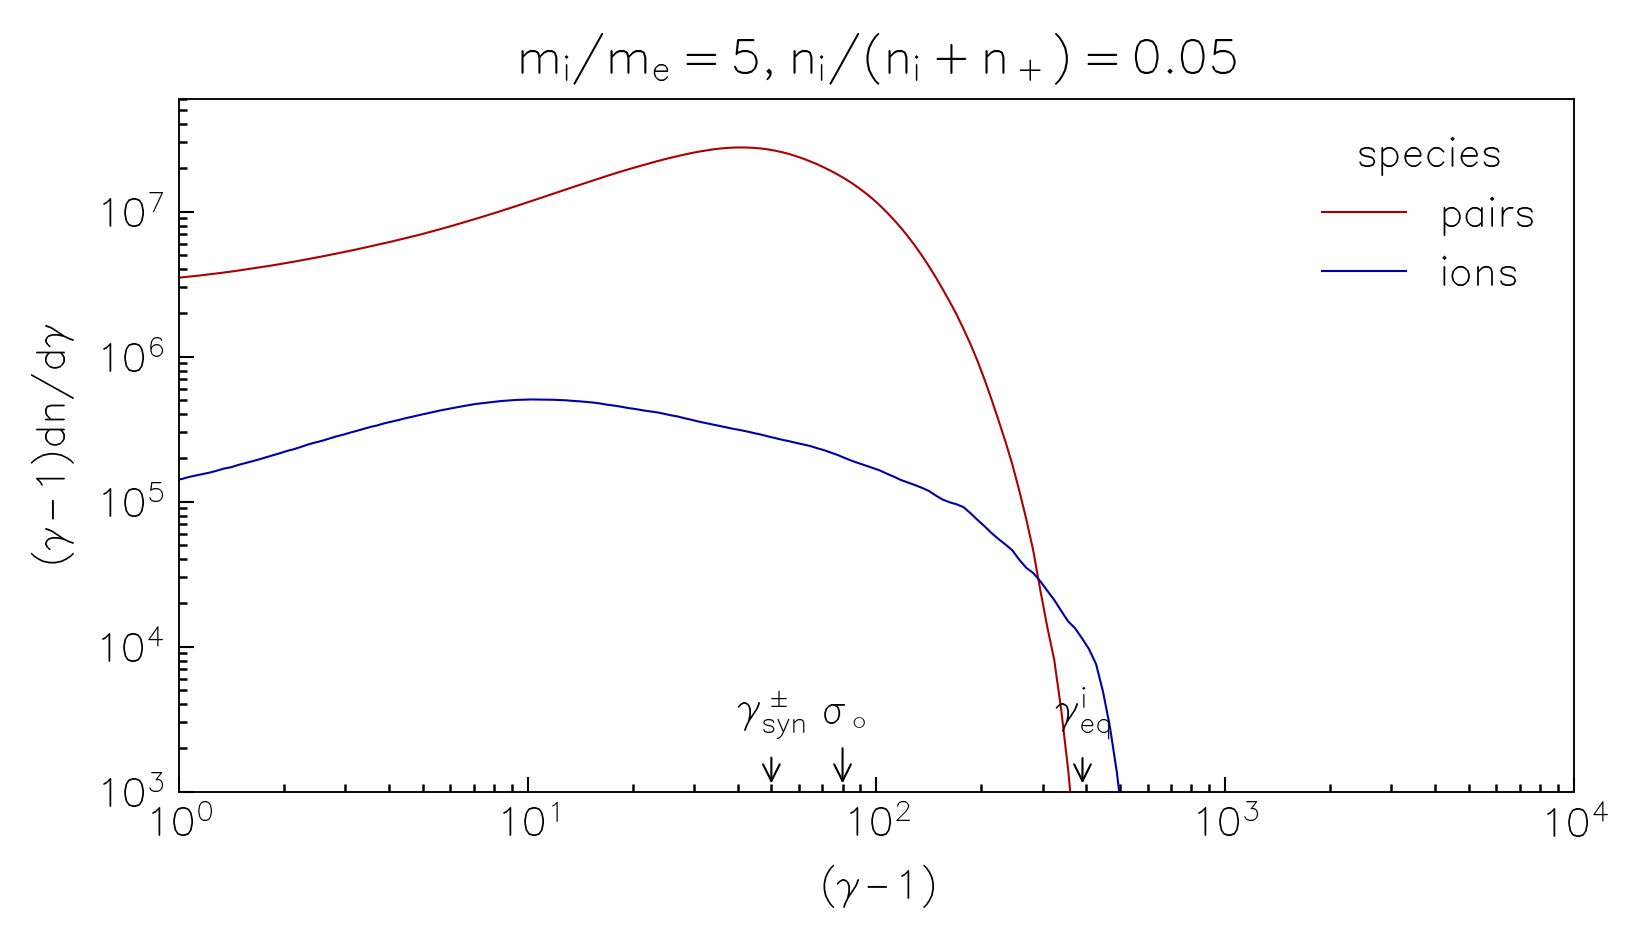

In [5]:
fig = plt.figure(figsize=(6, 3), dpi=300)
ax = fig.add_subplot(111)
(d.spectra.n4 + d.spectra.n5).sel(t=slice(1.5, 2.2)).mean("t").plot(
    ax=ax, label="pairs", c="C1"
)
ax.plot(
    d.spectra.e, d.spectra.n6.sel(t=slice(1.5, 2.2)).mean("t"), label="ions", c="C2"
)
ax.set(
    xscale="log",
    yscale="log",
    xlim=(1, 1e4),
    ylim=(1e3, 6e7),
    xlabel=r"$(\gamma-1)$",
    ylabel=r"$(\gamma - 1) dn/d\gamma$",
)
sigma_eff = d.params["plasma:sigma"] / (
    1 + d.params["problem:f_ions"] * d.params["particles:m6"]
)
gamma_syn = d.params["radiation:gamma_syn"]
gamma_eq = (
    gamma_syn * (2 / d.params["problem:f_ions"] - 1) * (1 / d.params["particles:m6"])
)
for g, lbl in zip(
    [sigma_eff, gamma_syn, gamma_eq],
    [r"$\sigma_\circ$", r"$\gamma_{\rm syn}^\pm$", r"$\gamma_{\rm eq}^i$"],
):
    ax.annotate(
        lbl,
        (g, 1e3),
        (g, 3e3),
        arrowprops=dict(arrowstyle="->", lw=0.5),
        ha="center",
    )
ax.legend(title="species")
_ = ax.set(
    title=rf"$m_i/m_e = {d.params['particles:m6']}$, $n_i/(n_i+n_+) = {d.params['problem:f_ions']}$"
)

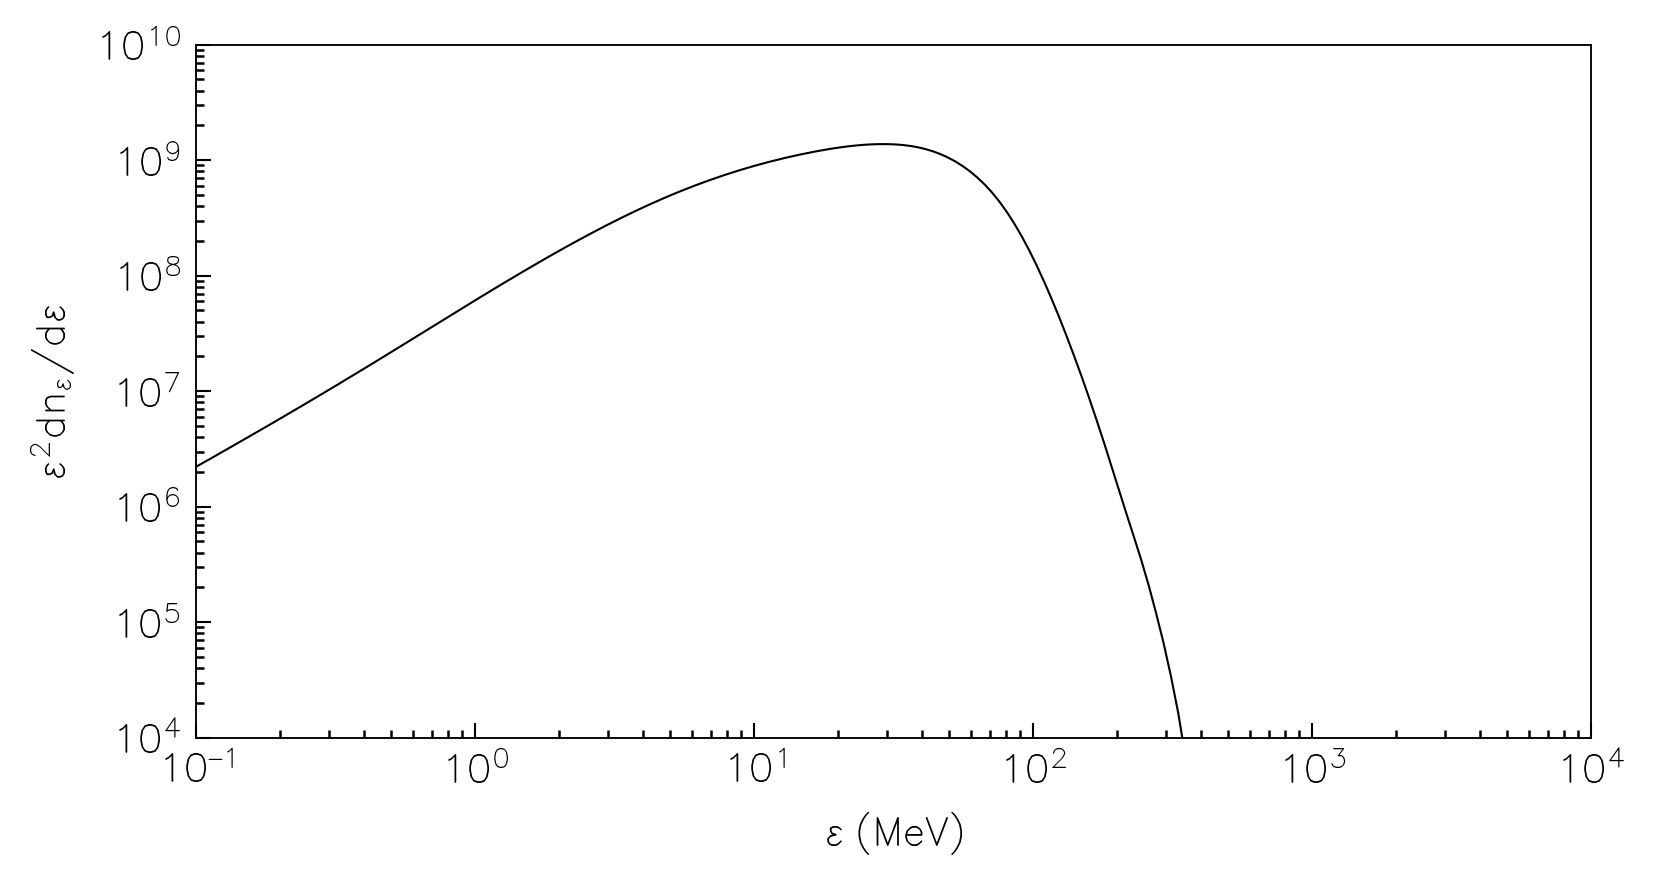

In [6]:
fig = plt.figure(figsize=(6, 3), dpi=300)
ax = fig.add_subplot(111)
ax.plot(
    d.spectra.coords["re"] * 0.511,
    (d.spectra.nr4 + d.spectra.nr5).sel(t=slice(1.5, 2.2)).mean("t")
    * d.spectra.coords["re"],
)
_ = ax.set(
    xscale="log",
    yscale="log",
    xlim=(1e-1, 1e4),
    ylim=(1e4, 1e10),
    xlabel=r"$\varepsilon$ (MeV)",
    ylabel=r"$\varepsilon^2 dn_\varepsilon/d\varepsilon$",
)

In [27]:
def get_emission(species, time):
    import xarray as xr

    sel_time = lambda d: d.sel(t=time, method="nearest")

    xs = sel_time(d.particles[species].x).values
    ys = sel_time(d.particles[species].y).values
    zs = sel_time(d.particles[species].z).values
    xs = xr.DataArray(xs[np.isfinite(xs)], dims="p")
    ys = xr.DataArray(ys[np.isfinite(ys)], dims="p")
    zs = xr.DataArray(zs[np.isfinite(zs)], dims="p")
    uxs = sel_time(d.particles[species].u).values
    uys = sel_time(d.particles[species].v).values
    uzs = sel_time(d.particles[species].w).values
    uxs = xr.DataArray(uxs[np.isfinite(uxs)], dims="p")
    uys = xr.DataArray(uys[np.isfinite(uys)], dims="p")
    uzs = xr.DataArray(uzs[np.isfinite(uzs)], dims="p")

    bxs = sel_time(d.fields.bx).load().sel(x=xs, y=ys, z=zs, method="nearest")
    bys = sel_time(d.fields.by).load().sel(x=xs, y=ys, z=zs, method="nearest")
    bzs = sel_time(d.fields.bz).load().sel(x=xs, y=ys, z=zs, method="nearest")
    exs = sel_time(d.fields.ex).load().sel(x=xs, y=ys, z=zs, method="nearest")
    eys = sel_time(d.fields.ey).load().sel(x=xs, y=ys, z=zs, method="nearest")
    ezs = sel_time(d.fields.ez).load().sel(x=xs, y=ys, z=zs, method="nearest")

    gamma = np.sqrt(1 + uxs**2 + uys**2 + uzs**2)
    beta_x = uxs / gamma
    beta_y = uys / gamma
    beta_z = uzs / gamma
    Eprime_x = exs + beta_y * bzs - beta_z * bys
    Eprime_y = eys + beta_z * bxs - beta_x * bzs
    Eprime_z = ezs + beta_x * bys - beta_y * bxs
    Eprime_cross_B_x = Eprime_y * bzs - Eprime_z * bys
    Eprime_cross_B_y = Eprime_z * bxs - Eprime_x * bzs
    Eprime_cross_B_z = Eprime_x * bys - Eprime_y * bxs
    beta_dot_E = beta_x * exs + beta_y * eys + beta_z * ezs
    chiRsqr = (
        Eprime_cross_B_x**2 + Eprime_cross_B_y**2 + Eprime_cross_B_z**2
    ) - beta_dot_E**2

    chiRsqr_v = chiRsqr.values
    gamma_v = gamma.values
    return gamma_v, chiRsqr_v

In [28]:
C = 0.45
B0 = C**2 * np.sqrt(d.params["plasma:sigma"]) / d.params["plasma:c_omp"]

In [29]:
gamma_e, chiRsqr_e = get_emission(4, 2)
gamma_p, chiRsqr_p = get_emission(5, 2)
gamma_i, chiRsqr_i = get_emission(6, 2)

In [32]:
np.savetxt(
    "../ion/postprocessing/ionrec-02/gamma_chiRsqr_e_time2.csv",
    [gamma_e, chiRsqr_e],
    delimiter=",",
)

In [33]:
np.savetxt(
    "../ion/postprocessing/ionrec-02/gamma_chiRsqr_p_time2.csv",
    [gamma_p, chiRsqr_p],
    delimiter=",",
)

In [34]:
np.savetxt(
    "../ion/postprocessing/ionrec-02/gamma_chiRsqr_i_time2.csv",
    [gamma_i, chiRsqr_i],
    delimiter=",",
)

In [62]:
def get_sync(gamma, chiRsqr, gamma_c, m):
    sync_e = (np.sqrt(chiRsqr) / B0) * (gamma / gamma_c) ** 2 / m
    sync_I = gamma**2 * chiRsqr / B0**2
    cnt = np.histogram(
        sync_e,
        bins=np.concatenate([d.spectra.re, d.spectra.re[-1:] + 1]),
        weights=sync_I / sync_e,
    )[0]
    return d.spectra.re, cnt

_, Pe = get_sync(
    gamma_e, chiRsqr_e, d.params["radiation:emit_gamma_syn"], d.params["particles:m4"]
)
_, Pp = get_sync(
    gamma_p, chiRsqr_p, d.params["radiation:emit_gamma_syn"], d.params["particles:m5"]
)
_, Pi = get_sync(
    gamma_i, chiRsqr_i, d.params["radiation:emit_gamma_syn"], d.params["particles:m6"]
)

/tmp/ipykernel_3628631/2744352463.py:2: RuntimeWarning: invalid value encountered in sqrt
  sync_e = (np.sqrt(chiRsqr) / B0) * (gamma / gamma_c) ** 2 / m


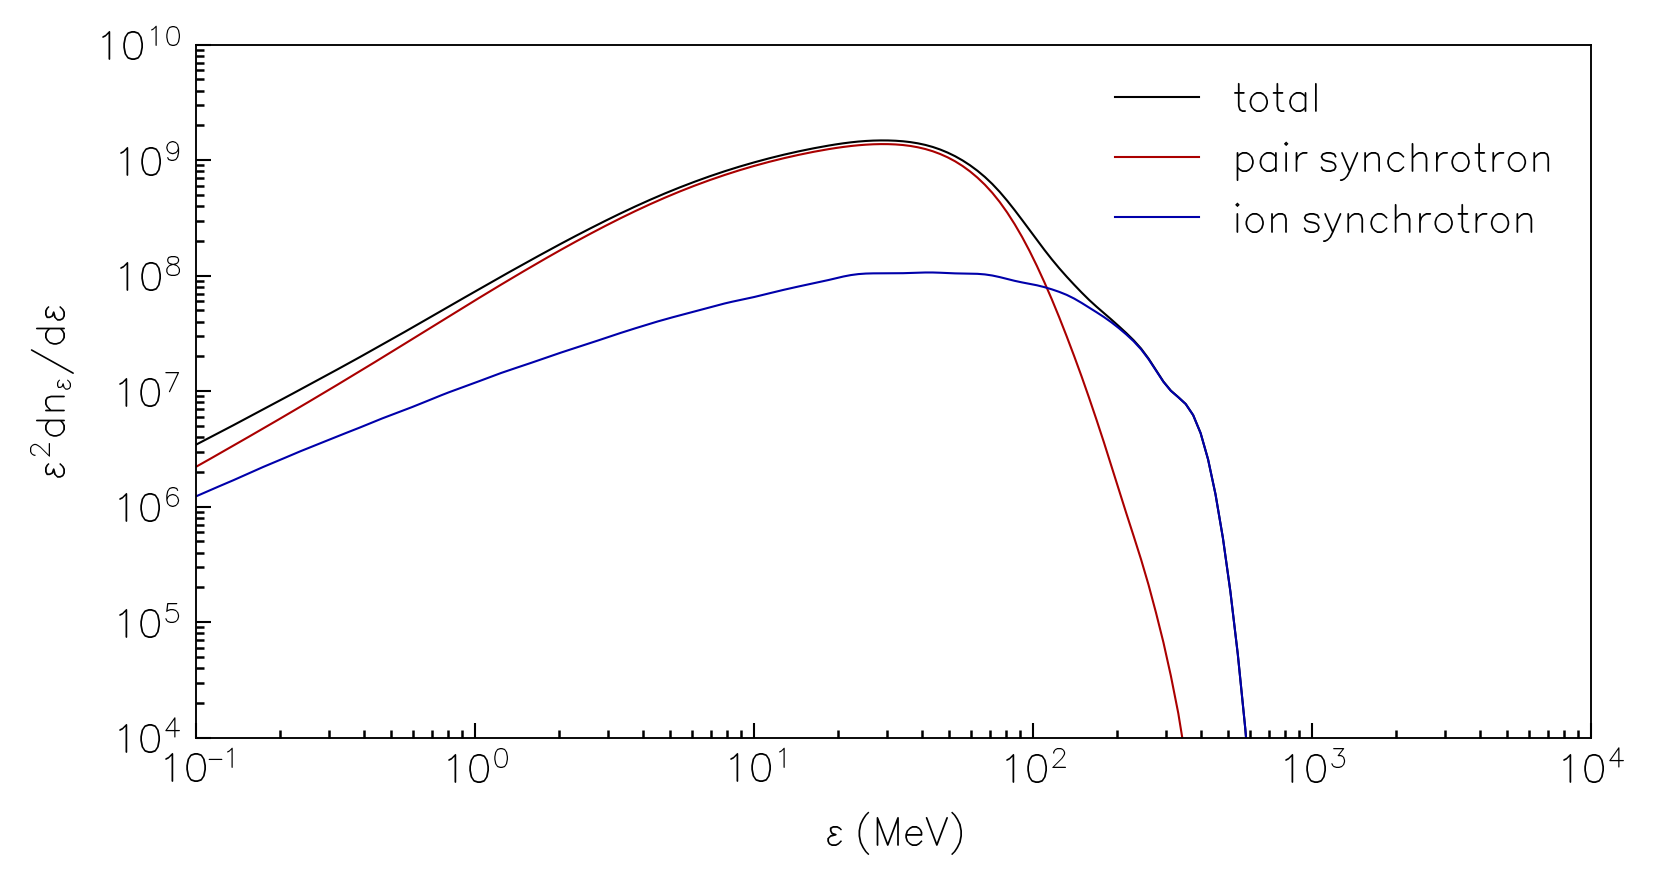

In [66]:
fig = plt.figure(figsize=(6, 3), dpi=300)
ax = fig.add_subplot(111)
ax.plot(
    d.spectra.coords["re"] * 0.511,
    (smooth(Pi, 2) * 15 + (d.spectra.nr4 + d.spectra.nr5).sel(t=2, method="nearest"))
    * d.spectra.coords["re"],
    label="total",
)
ax.plot(
    d.spectra.coords["re"] * 0.511,
    (d.spectra.nr4 + d.spectra.nr5).sel(t=2, method="nearest") * d.spectra.coords["re"],
    label="pair synchrotron",
)
ax.plot(
    d.spectra.coords["re"] * 0.511,
    smooth(Pi, 2) * 15 * d.spectra.coords["re"],
    label="ion synchrotron",
)
ax.legend()
_ = ax.set(
    xscale="log",
    yscale="log",
    xlim=(1e-1, 1e4),
    ylim=(1e4, 1e10),
    xlabel=r"$\varepsilon$ (MeV)",
    ylabel=r"$\varepsilon^2 dn_\varepsilon/d\varepsilon$",
)

TypeError: No numeric data to plot.

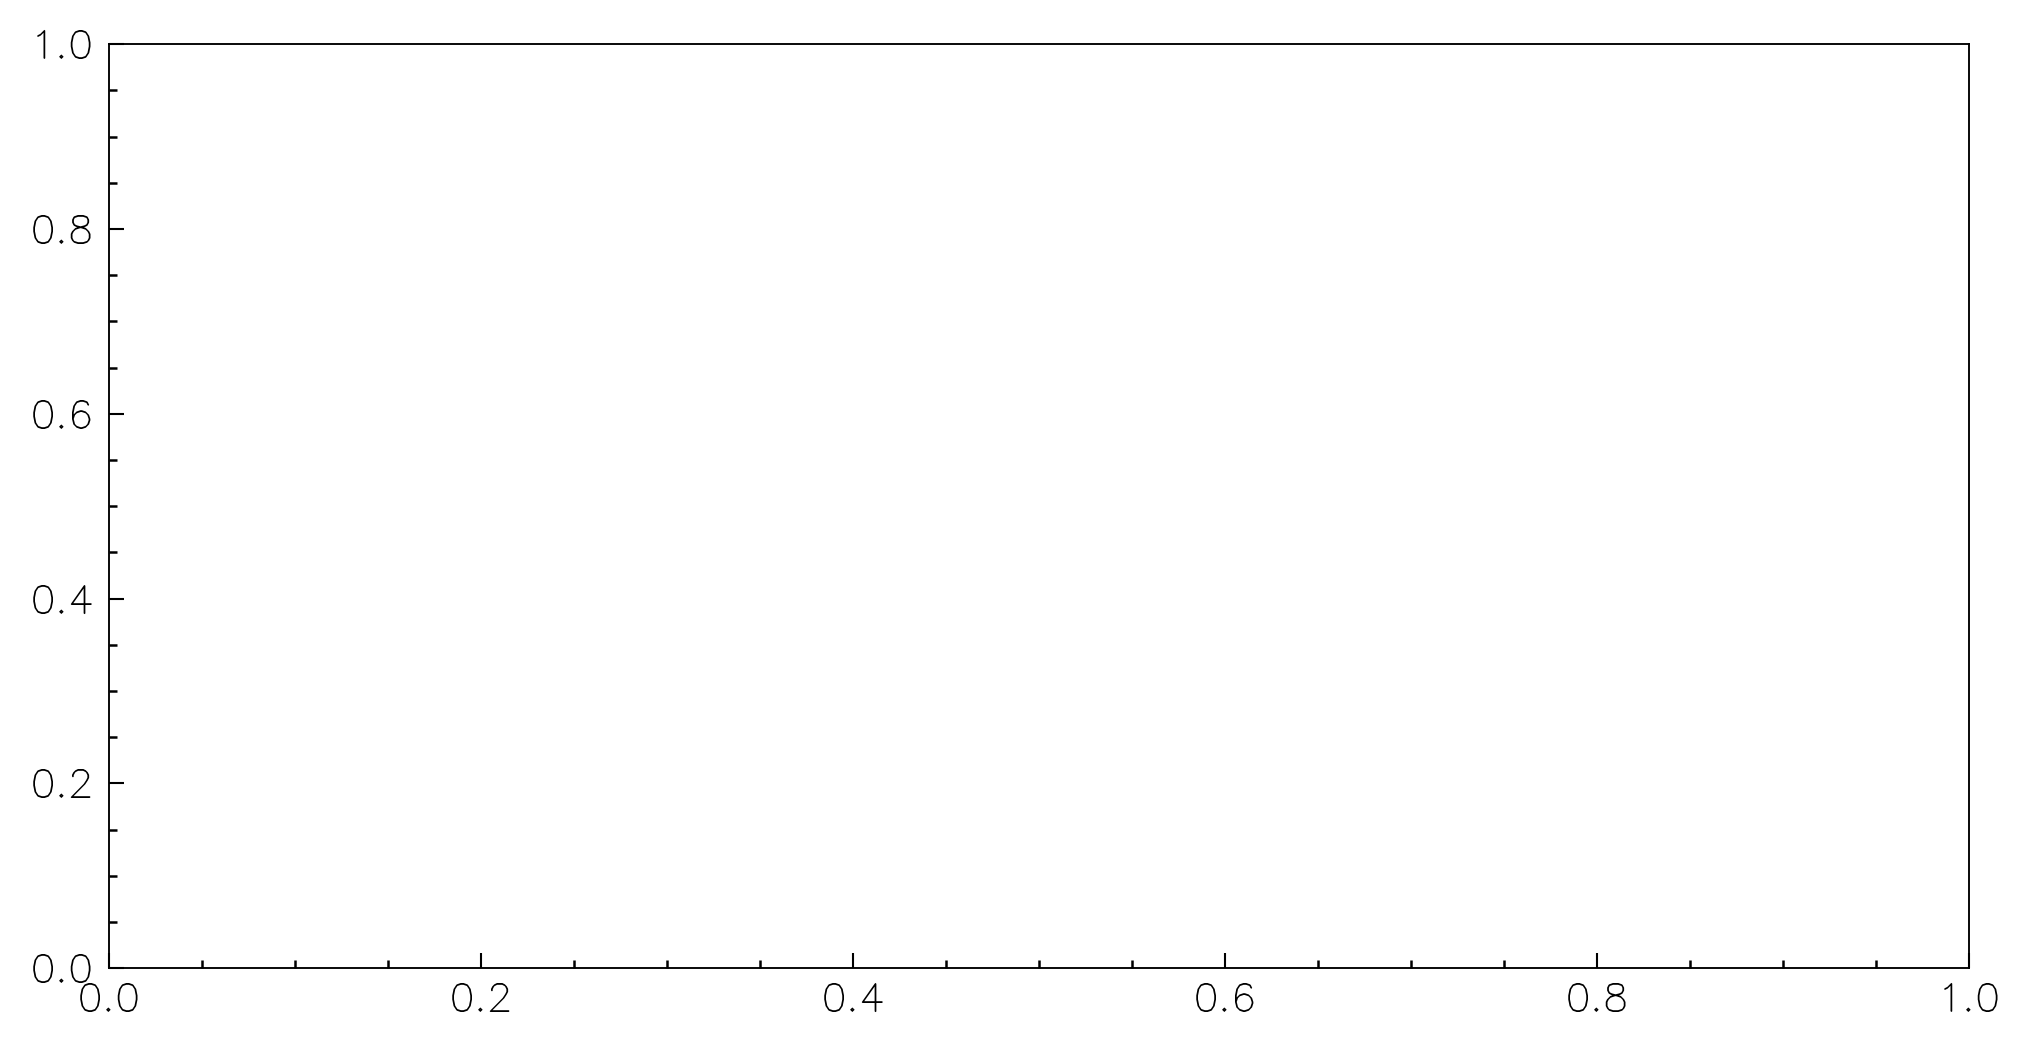

In [67]:
xmin, xmax = -0.5, 0.5
zmin, zmax = -0.2, 0.2

selection = (
    lambda d: d.T.sel(y=0, method="nearest")
    .sel(x=slice(-0.5, 0.5), z=slice(-0.2, 0.2))
    .sel(t=1.7, method="nearest")
)

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
selection(
    d.fields.dens1
    + d.fields.dens2
    + d.fields.dens3
    + d.fields.dens4
    + d.fields.dens5
    + d.fields.dens6
).plot(ax=ax, vmin=0, vmax=10, cmap="fire")
x = d.fields.coords["x"]
x = np.linspace(x.min(), x.max(), len(x))[(x > xmin) & (x < xmax)]
z = d.fields.coords["z"]
z = np.linspace(z.min(), z.max(), len(z))[(z > zmin) & (z < zmax)]
ax.streamplot(
    x,
    z,
    selection(d.fields.by),
    selection(d.fields.bx),
    color="red",
    arrowstyle="->",
    arrowsize=0.5,
)
_ = ax.set(aspect=1)

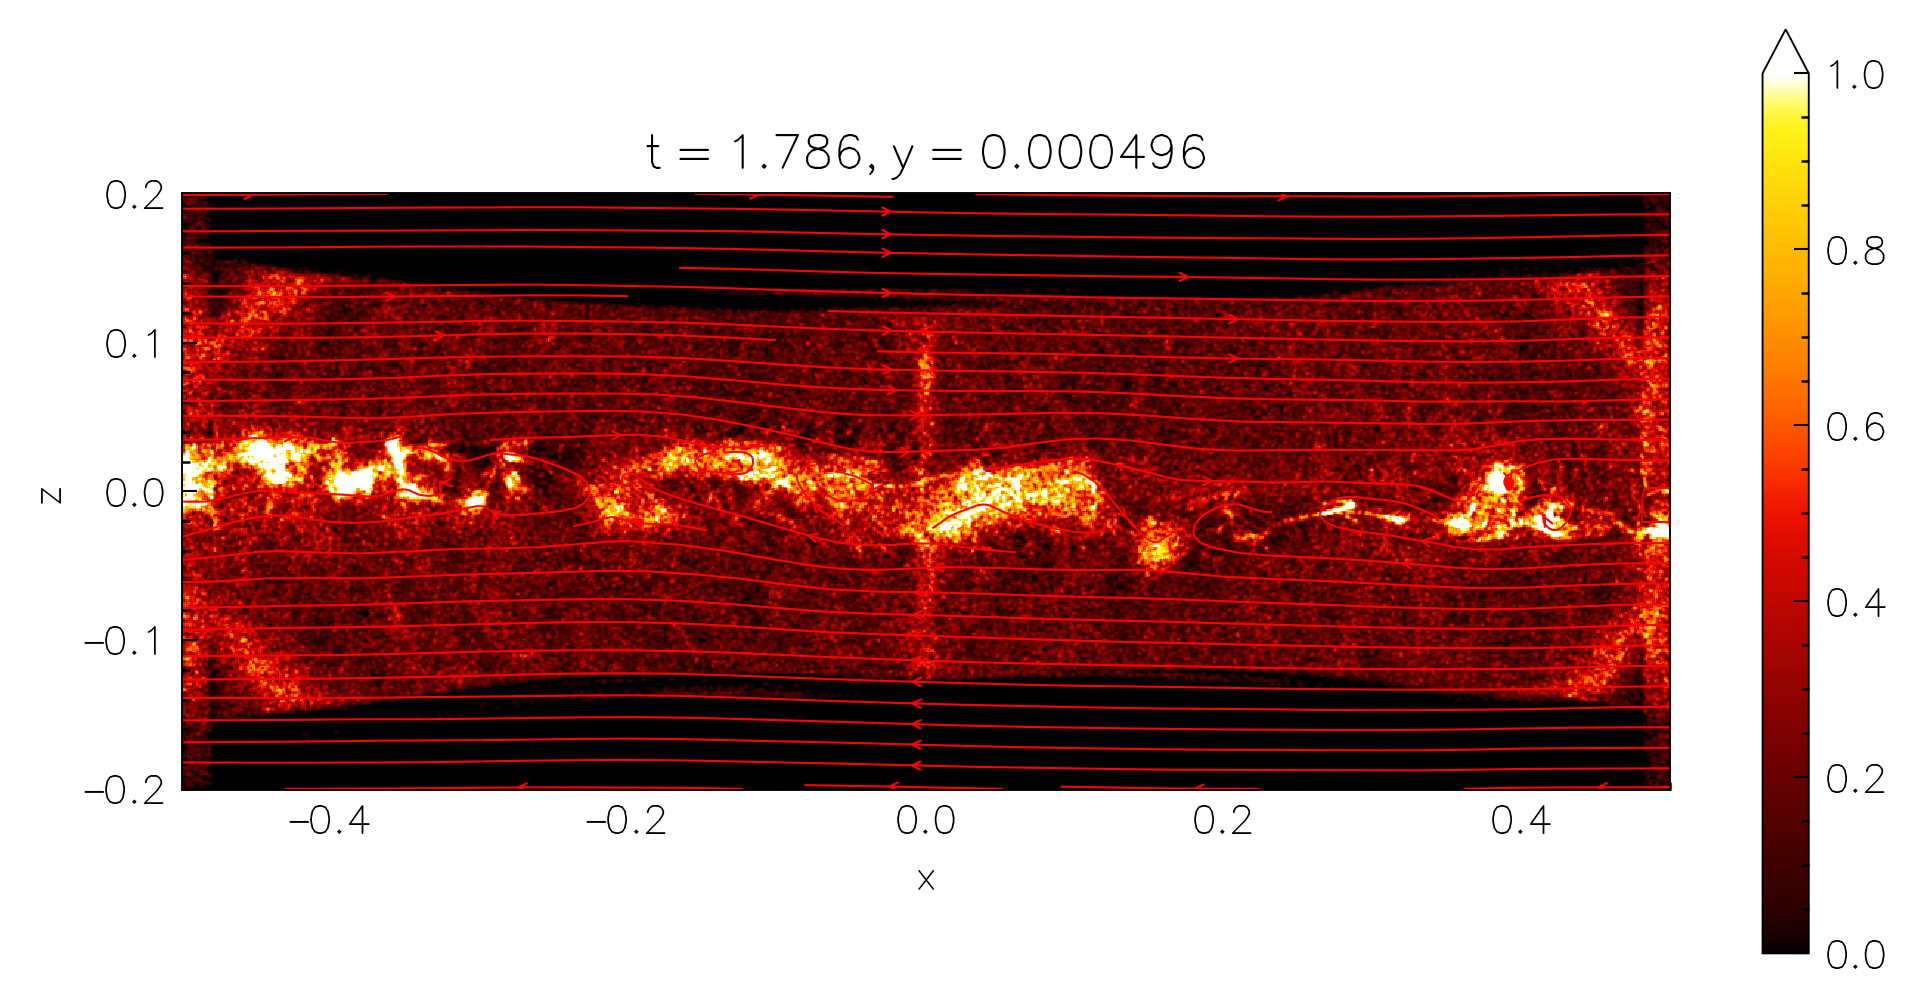

In [41]:
xmin, xmax = -0.5, 0.5
zmin, zmax = -0.2, 0.2

selection = (
    lambda d: d.T.sel(y=0, method="nearest")
    .sel(x=slice(-0.5, 0.5), z=slice(-0.2, 0.2))
    .sel(t=1.7, method="nearest")
)

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
selection(d.fields.dens3 + d.fields.dens6).plot(ax=ax, vmin=0, vmax=1, cmap="fire")
x = d.fields.coords["x"]
x = np.linspace(x.min(), x.max(), len(x))[(x > xmin) & (x < xmax)]
z = d.fields.coords["z"]
z = np.linspace(z.min(), z.max(), len(z))[(z > zmin) & (z < zmax)]
ax.streamplot(
    x,
    z,
    selection(d.fields.by),
    selection(d.fields.bx),
    color="red",
    arrowstyle="->",
    arrowsize=0.5,
)
_ = ax.set(aspect=1)

In [ ]:
e_vals = (d.fields.enrg4 + d.fields.enrg5).sum(("x", "y", "z"))

In [70]:
fig = plt.figure(figsize=(8, 4), dpi=300)
ax = fig.add_subplot(111)
(d.fields.enrg4 + d.fields.enrg5).sum(("x", "y", "z")).plot(ax=ax)

KeyboardInterrupt: 